# Capstone Project - Coffee Shop Decision (Week 2)
### Applied Data Science Capstone by IBM/Coursera

### Table of contents
* [Introduction: Business Problem](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Results](#Results)
* [Discussion](#Discussion)
* [Conclusion](#Conclusion)


## Introduction: Business Problem <a name="Introduction"></a>

### 1, Background

Toronto is an international metropolis with a population of more than 6 million and is also a Canadian economic, cultural and tourist destination. In Toronto, investing in a coffee shop should be a good business choice. 

Despite of the quality of your coffee, whether a coffee shop can be profitable depends mainly on whether there are enough potential customers. The number of potential customers is related to whether the coffee shop is located at a densely active crowd zone, such as parks, tourist attractions, gym, mall, etc. .Those zones generally have a large flow of people, and coffee shops will have better profit potential.

### 2 , Problem

This project will give suggestion on whether a location is suitable for investing in a coffee shop, and the answer would be yes/no. 

The decision will based on the analyze the venues near the coffee shop suggesting that a good coffee shop location is mainly related to the nearby venues.  

From Foursquare website , we can acquire the number of customers and popularity data of existing cafes. Then found the relationship between the number of customers in the coffee shop and the VENUE type/quantity near the coffee shop. Finally , I will build a decision model with the highest accuracy through the classification algorithm.

## Data <a name="Data"></a>

### 1.1, Data Source   Toronto Neighborhood
Postcode、Borough and Neighborhood data of Toronto can be found in WIKI website “https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M”.

From "https://cocl.us/Geospatial_data" we can acquire Latitude and Longitude data of each neighborhood.

       Columns : Index | Postcode | Neighborhood | Latitude | Longtitude
       
Data will be filter and clean with unique value of each neighborhood name.

In [11]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import json

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wd_data=requests.get(url)

soup=BeautifulSoup(wd_data.text,"html.parser")
table=soup.find_all('table')[0]
tablerows=table.find_all('tr')

res=[]
for tr in tablerows:
    td=tr.find_all('td')
    row=[tr.text.strip() for tr in td]
    if row:
        res.append(row)
df=pd.DataFrame(res,columns=["Postcode","Borough","Neighborhood"]) 

# Cleaning and processing data

df = df.drop(df[df["Borough"].str.contains('Not assigned')].index)
df = df.drop(df[df["Neighborhood"].str.contains('Not assigned')].index)
df = df.drop_duplicates(subset='Neighborhood',keep='first')

df=df.sort_values(by=["Borough",'Postcode'] , ascending=True) 
df=df.reset_index(drop='Ture')


# Build Toronto Borough and Neighborhood DataSet

toronto_borough=df['Borough'].unique()
toronto_postcode=df['Postcode'].unique()

toronto_neighborhood=df

print('Toronto Neighborhood Total: {}.'.format(toronto_neighborhood.shape[0]))
print('Toronto Borough Total: {}.'.format(toronto_borough.shape[0]))
print('Toronto PostalCode Total: {}.'.format(toronto_postcode.shape[0]))

toronto_neighborhood.head(10)

Toronto Neighborhood Total: 208.
Toronto Borough Total: 10.
Toronto PostalCode Total: 102.


,Postcode,Borough,Neighborhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,North Toronto West
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,Moore Park
5,M4T,Central Toronto,Summerhill East
6,M4V,Central Toronto,Deer Park
7,M4V,Central Toronto,Forest Hill SE
8,M4V,Central Toronto,Rathnelly
9,M4V,Central Toronto,South Hill


In [14]:
# Add Geo Data
lurl='https://cocl.us/Geospatial_data'
df=pd.read_csv(lurl)

dfres=toronto_neighborhood

latitude=df['Latitude']
longitude=df['Longitude']
dfres['Latitude']=latitude
dfres['Longitude']=longitude

print(dfres.shape)

for i in range(0,dfres.shape[0]):
    rr=df[df['Postal Code']==dfres.iloc[i,0]]
    dfres['Latitude'][i]=rr['Latitude']
    dfres['Longitude'][i]=rr['Longitude']

dfres.head(10)




(208, 5)


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,Moore Park,43.689574,-79.383160
5,M4T,Central Toronto,Summerhill East,43.689574,-79.383160
6,M4V,Central Toronto,Deer Park,43.686412,-79.400049
7,M4V,Central Toronto,Forest Hill SE,43.686412,-79.400049
8,M4V,Central Toronto,Rathnelly,43.686412,-79.400049
9,M4V,Central Toronto,South Hill,43.686412,-79.400049


### 1.2, Data Source - Venue of CoffeeShop
Foursquare provide Venue dataset , we explore recommanded coffeeshops ,include Venue Name, Venue category and Venue location data , to cluster/group and compare venues in a neighborhood. 

With detail data for each Coffee Shop , we will use it to analyze the business situation with data of Venue.stats(user checkin Count) 

       Columns : Venue ID | Venue Name | Postcode | Category(CoffeeShop) | Stats(checkinsCnt) | Latitude| Longtitude

In [15]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import requests 
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib 
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import folium package
#get_ipython().system(u'pip install folium')


address = 'Toronto,Canada'

geolocator = Nominatim(user_agent="ny_explorer")
t_location = geolocator.geocode(address)
t_latitude = t_location.latitude
t_longitude = t_location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(t_latitude, t_longitude))

# Retreive Toronto CoffeeShop data form Foursquare

#CLIENT_ID = 'F23I2U23J3ZLZWHOXETTKM0LAFORD252GAEYWXRHGFQWFGTY' 
#CLIENT_SECRET = 'FUVY5QGKF2B31RN4RPMUY0VX3POUU12ATO32PYC0VOGRM0OE' 
CLIENT_ID='OL50YGYJNMSCDKEBP3EBZ0KAUUI2B4VOTBS2VTTGXDVU0MSR'
CLIENT_SECRET='KNGRVZV0DMJ4TUAQCVJZ4RNNSFF5CNDTLCPRX24U5DJAZVP2'
VERSION = '20180605'
SECTION='coffee'
QUERY='coffeeshop'

LIMIT = 100
RADIUS = 10000


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    t_latitude, 
    t_longitude, 
    SECTION,
    RADIUS,
    LIMIT   
    )

'''
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    t_latitude, 
    t_longitude, 
    QUERY,
    RADIUS,
    LIMIT   
    )
'''
results = requests.get(url).json()
#print(results)

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# function that extracts the stats.checkinsCount of the venue
def get_stats_checkinsCount(row):
    try:
        stats_list = row['stats']
    except:
        stats_list = []
       
    if len(stats_list) == 0:
        return None
    else:
        return stats_list[0]['checkinsCount']


#venues = results['response']['venues']
venues = results['response']['groups'][0]['items']

    
coffee_venues = json_normalize(venues) # flatten JSON

# filter columns
#filtered_columns = ['id','name', 'categories.0.name','location.postalCode','location.lat', 'location.lng','stats.checkinsCount']
filtered_columns = ['venue.id','venue.name', 'venue.categories','venue.location.postalCode','venue.location.lat', 'venue.location.lng','venue.stats.checkinsCount']

coffee_venues =coffee_venues.loc[:, filtered_columns]

# filter the category for each row
coffee_venues['venue.categories'] = coffee_venues.apply(get_category_type, axis=1)

# filter the stats for each row
#coffee_venues['venue.checkinsCount'] = coffee_venues.apply(get_stats_checkinsCount, axis=1)

# clean columns  ???
coffee_venues.columns = ['venue_id','venue_name','category','postalCode','latitude','longitude','checkinsCount']


print('{} coffee_venues were returned by Foursquare.'.format(coffee_venues.shape[0]))

coffee_venues.head(10)



The geograpical coordinate of Toronto are 43.653963, -79.387207.
100 coffee_venues were returned by Foursquare.


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:104: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,venue_id,venue_name,category,postalCode,latitude,longitude,checkinsCount
0,5a81ae339deb7d369fa7f146,Hailed Coffee,Coffee Shop,M5G,43.658833,-79.383684,NaN
1,537d4d6d498ec171ba22e7fe,Jimmy's Coffee,Coffee Shop,M5G 1Z4,43.658421,-79.385613,NaN
2,514627d1e4b0dba1b85e9ba8,Dineen Coffee,Café,M5C 1X6,43.650497,-79.378765,NaN
3,59cd51c71b0ea516e9e7b3aa,Pilot Coffee Roasters,Coffee Shop,M5X,43.648835,-79.380936,NaN
4,56d4d1b3cd1035fe77e1492c,Page One Cafe,Café,M5B 2R7,43.657772,-79.376073,NaN
5,4fff1f96e4b042ae8acddca5,Fahrenheit Coffee,Coffee Shop,M5C 3H5,43.652384,-79.372719,NaN
6,5830bf495d6ec631f622902f,Little Pebbles,Coffee Shop,M5T 1L8,43.654883,-79.400264,NaN
7,52138db911d22803b334c641,Mos Mos Coffee,Café,NaN,43.648159,-79.378745,NaN
8,4a8d5b48f964a520840f20e3,The Moonbean Cafe,Café,M5T 1K6,43.654147,-79.400182,NaN
9,58a1d1a8326c5a3a1c150a60,Strange Love,Coffee Shop,M5V 2K2,43.646301,-79.395184,NaN


In [16]:
# Get checkinsCount data for each coffee-shop and save to checkinsCount_dataset
import pandas as pd
from pandas import Series,DataFrame
'''
venue_id=coffee_venues.iloc[0,0]

print("venue_id is %s" %(venue_id))

categoryId="4bf58dd8d48988d1e0931735"
      
#url='https://foursquare.com/developers/explore#req=venues%2F49eeaf08f964a52078681fe3%3F'

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&venue_id={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    VERSION,
    t_latitude,
    t_longitude,
    venue_id)

results = requests.get(url).json()
'''
checkinsCount_dataset1=Series([733,825,521,285,3838,3776,1707,2702,3389,1286,1956,492,429,314,4004,1439,1254,264,164,1782,406,432,232,11114,5859,326,1513,5562,1304,901,340,6870,796,1322,2126,1429,356,925,1453,1040,9103,903,399,1162,5630,2875,2949,300,305,571,6419,2923,902,362,593,1157,1390,1982,170,561])
checkinsCount_dataset2=Series([722,2923,201,428,582,1001,2423,5492,1323,199,292,232,2525,2001,299,323,242,224,2999,5299,1112,2328,1999,192,420,485,1882,2472,2242,152,132,5324,1121,2422,423,728,212,232,456,2534,5231,232,2321,627,112,124,521])

for i in range(100):
    if i < 60:
        coffee_venues.loc[i,'checkinsCount']=checkinsCount_dataset1[i]
    else:
        coffee_venues.loc[i,'checkinsCount']=checkinsCount_dataset2[i-60]

coffee_venues.head(10)


,venue_id,venue_name,category,postalCode,latitude,longitude,checkinsCount
0,5a81ae339deb7d369fa7f146,Hailed Coffee,Coffee Shop,M5G,43.658833,-79.383684,733.0
1,537d4d6d498ec171ba22e7fe,Jimmy's Coffee,Coffee Shop,M5G 1Z4,43.658421,-79.385613,825.0
2,514627d1e4b0dba1b85e9ba8,Dineen Coffee,Café,M5C 1X6,43.650497,-79.378765,521.0
3,59cd51c71b0ea516e9e7b3aa,Pilot Coffee Roasters,Coffee Shop,M5X,43.648835,-79.380936,285.0
4,56d4d1b3cd1035fe77e1492c,Page One Cafe,Café,M5B 2R7,43.657772,-79.376073,3838.0
5,4fff1f96e4b042ae8acddca5,Fahrenheit Coffee,Coffee Shop,M5C 3H5,43.652384,-79.372719,3776.0
6,5830bf495d6ec631f622902f,Little Pebbles,Coffee Shop,M5T 1L8,43.654883,-79.400264,1707.0
7,52138db911d22803b334c641,Mos Mos Coffee,Café,NaN,43.648159,-79.378745,2702.0
8,4a8d5b48f964a520840f20e3,The Moonbean Cafe,Café,M5T 1K6,43.654147,-79.400182,3389.0
9,58a1d1a8326c5a3a1c150a60,Strange Love,Coffee Shop,M5V 2K2,43.646301,-79.395184,1286.0


## Methodology <a name="Methodology"></a>

### 2.1, Cluster CoffeeShops by K-Means



In [17]:
from sklearn.cluster import KMeans
import random
import numpy as np

coffee_clustering=coffee_venues[['latitude','longitude']].astype('float')
coffee_clustering.head()

coffee_clustering['longitude']=np.abs(coffee_clustering['longitude'])
coffee_clustering.head()

KCLUSTERS = 4

# run k-means clustering
kmeans = KMeans(n_clusters=KCLUSTERS, random_state=0).fit(coffee_clustering)

# check cluster labels generated for each row in the dataframe
print('KMEANS RESULT: Labels:-----------------')
print(kmeans.labels_)

print('KMEANS RESULT: CenterPoint:-----------------')
print(kmeans.cluster_centers_)


KMEANS RESULT: Labels:-----------------
[2 2 2 2 2 2 1 2 1 1 1 1 2 1 0 2 1 2 1 1 1 2 2 0 1 1 3 2 2 1 1 2 1 1 2 2 1
 0 1 1 2 2 0 2 2 1 2 1 2 0 0 2 1 1 3 2 1 2 2 0 2 2 2 0 3 1 3 2 1 2 0 1 2 0
 1 2 1 2 0 1 2 3 2 1 2 1 1 1 0 0 1 1 1 2 1 2 3 3 1 1]
KMEANS RESULT: CenterPoint:-----------------
[[ 43.65552744  79.35961095]
 [ 43.65044831  79.40568457]
 [ 43.65017017  79.3824211 ]
 [ 43.67254407  79.39030803]]


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


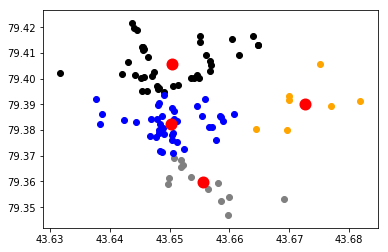

In [18]:
# show data in plot map
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import cluster
import numpy as np
import matplotlib.pyplot as plt


data=coffee_clustering

lable_pred=kmeans.labels_
centroids=kmeans.cluster_centers_

for i in range(0,len(lable_pred)):
    if int(lable_pred[i])==0:
        plt.scatter(data.ix[i,0],data.ix[i,1],color='grey')
    if int(lable_pred[i])==1:
        plt.scatter(data.ix[i,0],data.ix[i,1],color='black')
    if int(lable_pred[i])==2:
        plt.scatter(data.ix[i,0],data.ix[i,1],color='blue')
    if int(lable_pred[i])==3:
        plt.scatter(data.ix[i,0],data.ix[i,1],color='orange')
    if int(lable_pred[i])==4:
        plt.scatter(data.ix[i,0],data.ix[i,1],color='green')
        
plt.scatter(centroids[:,0],centroids[:,1],marker='o',
                s=100,linewidths=2,color='red',zorder=5,facecolors='red')
 
   
plt.show()

### 2.2, Analyse Nearby Venues around center point

In [19]:
# Retrieve nearby venues around Center Point


def getNearbyVenues(names, latitudes, longitudes, radius,limit):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()
        
        res= results['response']['groups'][0]['items']
        
        #v=json_normalize(vs)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in res])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['CenterPoint', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Category']
    
    return(nearby_venues)

# get nearby venues of each center point

temp=[{'center_lable':i,'latitude':centroids[i,0],'longitude':centroids[i,1]*-1} for i in range(KCLUSTERS)]
cluster_result=pd.DataFrame(data=temp)

cluster_result.head()

nearby_venues = getNearbyVenues(names=cluster_result['center_lable'],
                                   latitudes=cluster_result['latitude'],
                                   longitudes=cluster_result['longitude'],radius=1000,limit=100
                               )

nearby_venues=nearby_venues[~nearby_venues.Category.str.contains('Coffee')]
nearby_venues=nearby_venues[~nearby_venues.Category.str.contains('Café')]

nearby_venues.head(10)



,CenterPoint,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,0,43.655527,-79.359611,Impact Kitchen,43.656369,-79.356980,Restaurant
2,0,43.655527,-79.359611,Roselle Desserts,43.653447,-79.362017,Bakery
4,0,43.655527,-79.359611,Corktown Common,43.655618,-79.356211,Park
5,0,43.655527,-79.359611,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
6,0,43.655527,-79.359611,Dominion Pub and Kitchen,43.656919,-79.358967,Pub
7,0,43.655527,-79.359611,Underpass Park,43.655764,-79.354806,Park
8,0,43.655527,-79.359611,Souk Tabule,43.653756,-79.354390,Mediterranean Restaurant
10,0,43.655527,-79.359611,Body Blitz Spa East,43.654735,-79.359874,Spa
11,0,43.655527,-79.359611,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
12,0,43.655527,-79.359611,The Distillery Historic District,43.650244,-79.359323,Historic Site


In [20]:
#Analyse Nearby Venue category group and count of  each Centerpoint

for i in range(KCLUSTERS):
    nearby_0=nearby_venues[nearby_venues['CenterPoint']==i]
    venues_groupby=nearby_0['Venue'].groupby(nearby_0['Category'])
    df=venues_groupby.count()
    dtt=df.to_frame(name='Count')
    dtt=dtt.sort_values(by='Count',ascending=False)
    print('Top 10 Nearby venue Categroy of CenterPoint [%d]' %(i))
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print(dtt.head(10))

print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('End of Analyse Nearby Venue')

Top 10 Nearby venue Categroy of CenterPoint [0]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                       Count
Category                    
Bakery                     5
Theater                    4
Restaurant                 4
Italian Restaurant         4
Gym / Fitness Center       3
Thai Restaurant            3
Park                       3
Pub                        2
Performing Arts Venue      2
Sushi Restaurant           2
Top 10 Nearby venue Categroy of CenterPoint [1]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                               Count
Category                            
Bar                                7
Bakery                             4
Vegetarian / Vegan Restaurant      4
Sandwich Place                     3
Pizza Place                        3
Cocktail Bar                       3
Yoga Studio                        2
Furniture / Home Store             2
Restaurant                         2
Dessert Shop     

### 2.3, Feature selection for CoffeeShop decision model

In [21]:
#With analyze of Top 10 nearby venue of each center point , choose features below as decision input parameters

Features=Series(['Restaurant','Bar','Shop&Store','Place','Gym&Park'])
print("Features selected to coffeeshop decision input param-------")
Features


Features selected to coffeeshop decision input param-------


0    Restaurant
1           Bar
2    Shop&Store
3         Place
4      Gym&Park
dtype: object

### 2.4 Mark GOOD/BAD coffeeshop according to checkinCounts

In [22]:
# get checkinsCount mean number of all explored coffeeshop
median=coffee_venues.loc[:49,'checkinsCount'].median()

print("Median number of coffeeshop checkinsCount : %f"%median)

# mark GOOD/BAD coffeeshop
coffee_venues['Mark']=coffee_venues.checkinsCount.apply(lambda x: 'GOOD' if x>median else 'BAD')

coffee_venues.head(20)


Median number of coffeeshop checkinsCount : 1208.000000


,venue_id,venue_name,category,postalCode,latitude,longitude,checkinsCount,Mark
0,5a81ae339deb7d369fa7f146,Hailed Coffee,Coffee Shop,M5G,43.658833,-79.383684,733.0,BAD
1,537d4d6d498ec171ba22e7fe,Jimmy's Coffee,Coffee Shop,M5G 1Z4,43.658421,-79.385613,825.0,BAD
2,514627d1e4b0dba1b85e9ba8,Dineen Coffee,Café,M5C 1X6,43.650497,-79.378765,521.0,BAD
3,59cd51c71b0ea516e9e7b3aa,Pilot Coffee Roasters,Coffee Shop,M5X,43.648835,-79.380936,285.0,BAD
4,56d4d1b3cd1035fe77e1492c,Page One Cafe,Café,M5B 2R7,43.657772,-79.376073,3838.0,GOOD
5,4fff1f96e4b042ae8acddca5,Fahrenheit Coffee,Coffee Shop,M5C 3H5,43.652384,-79.372719,3776.0,GOOD
6,5830bf495d6ec631f622902f,Little Pebbles,Coffee Shop,M5T 1L8,43.654883,-79.400264,1707.0,GOOD
7,52138db911d22803b334c641,Mos Mos Coffee,Café,NaN,43.648159,-79.378745,2702.0,GOOD
8,4a8d5b48f964a520840f20e3,The Moonbean Cafe,Café,M5T 1K6,43.654147,-79.400182,3389.0,GOOD
9,58a1d1a8326c5a3a1c150a60,Strange Love,Coffee Shop,M5V 2K2,43.646301,-79.395184,1286.0,GOOD


### 2.5 Analyse nearby venues of each coffeeshop 

In [23]:
coffee_combined=pd.DataFrame(columns=['venue_id','venue_name','latitude','longitude','Mark','F1_count','F2_count','F3_count','F4_count','F5_count'])

for i in range(99):
    nearby_venues = getNearbyVenues(names=coffee_venues.loc[i:i,'venue_id'],
                                       latitudes=coffee_venues.loc[i:i,'latitude'],
                                       longitudes=coffee_venues.loc[i:i,'longitude'],radius=500,limit=50
                                   )
    nearby_venues=nearby_venues[~nearby_venues.Category.str.contains('Coffee')]
    nearby_venues=nearby_venues[~nearby_venues.Category.str.contains('Café')]

    venues_groupby=nearby_venues['Venue'].groupby(nearby_venues['Category'])
    df=venues_groupby.count()
    dtt=df.to_frame(name='Count')

    f1_count=dtt[dtt.index.str.contains('Restaurant')].count()
    f2_count=dtt[dtt.index.str.contains('Bar')].count()
    f3_count_1=dtt[dtt.index.str.contains('Shop')].count()
    f3_count_2=dtt[dtt.index.str.contains('Shop')].count()
    f3_count=f3_count_1+f3_count_2
    f4_count=dtt[dtt.index.str.contains('Place')].count()
    f5_count_1=dtt[dtt.index.str.contains('Gym')].count()
    f5_count_2=dtt[dtt.index.str.contains('Park')].count()
    f5_count=f5_count_1+f5_count_2

    coffee_combined.loc[i,'venue_id']=coffee_venues.loc[i,'venue_id']
    coffee_combined.loc[i,'venue_name']=coffee_venues.loc[i,'venue_name']
    coffee_combined.loc[i,'latitude']=coffee_venues.loc[i,'latitude']
    coffee_combined.loc[i,'longitude']=coffee_venues.loc[i,'longitude']
    coffee_combined.loc[i,'Mark']=coffee_venues.loc[i,'Mark']
    coffee_combined.loc[i,'F1_count']=f1_count[0]
    coffee_combined.loc[i,'F2_count']=f2_count[0]
    coffee_combined.loc[i,'F3_count']=f3_count[0]
    coffee_combined.loc[i,'F4_count']=f4_count[0]
    coffee_combined.loc[i,'F5_count']=f5_count[0]


print(coffee_combined.shape)    
coffee_combined.head(20)



(99, 10)


,venue_id,venue_name,latitude,longitude,Mark,F1_count,F2_count,F3_count,F4_count,F5_count
0,5a81ae339deb7d369fa7f146,Hailed Coffee,43.6588,-79.3837,BAD,12,2,8,2,1
1,537d4d6d498ec171ba22e7fe,Jimmy's Coffee,43.6584,-79.3856,BAD,12,2,8,3,2
2,514627d1e4b0dba1b85e9ba8,Dineen Coffee,43.6505,-79.3788,BAD,8,2,2,1,2
3,59cd51c71b0ea516e9e7b3aa,Pilot Coffee Roasters,43.6488,-79.3809,BAD,8,2,2,3,2
4,56d4d1b3cd1035fe77e1492c,Page One Cafe,43.6578,-79.3761,GOOD,9,2,8,4,1
5,4fff1f96e4b042ae8acddca5,Fahrenheit Coffee,43.6524,-79.3727,GOOD,7,1,2,2,1
6,5830bf495d6ec631f622902f,Little Pebbles,43.6549,-79.4003,GOOD,10,3,12,2,0
7,52138db911d22803b334c641,Mos Mos Coffee,43.6482,-79.3787,GOOD,9,2,6,1,3
8,4a8d5b48f964a520840f20e3,The Moonbean Cafe,43.6541,-79.4002,GOOD,10,4,14,1,0
9,58a1d1a8326c5a3a1c150a60,Strange Love,43.6463,-79.3952,GOOD,12,1,10,3,1


### 2.6 Decision Models
#### We will use the following algorithm:
#### - K Nearest Neighbor(KNN)
#### - Decision Tree
#### - Support Vector Machine
#### - Logistic Regression

In [24]:
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
from random import randint
import matplotlib.ticker as ticker
from sklearn import preprocessing
get_ipython().magic(u'matplotlib inline')

# contain evaluation cases
coffee_eval=pd.DataFrame(columns=['venue_id','venue_name','Mark','F1_count','F2_count','F3_count','F4_count','F5_count','Loc'])

coffee_set=coffee_combined

print(coffee_set.shape)
print(coffee_combined.shape)
for i in range(10):
    rs=random.randint(0,99)
    print(rs)
    coffee_eval.loc[i,'Loc']=rs
    coffee_eval.loc[i,'venue_id']=coffee_combined.loc[rs,'venue_id']
    coffee_eval.loc[i,'venue_name']=coffee_combined.loc[rs,'venue_name']
    coffee_eval.loc[i,'Mark']=coffee_combined.loc[rs,'Mark']
    coffee_eval.loc[i,'F1_count']=coffee_combined.loc[rs,'F1_count']
    coffee_eval.loc[i,'F2_count']=coffee_combined.loc[rs,'F2_count']
    coffee_eval.loc[i,'F3_count']=coffee_combined.loc[rs,'F3_count']
    coffee_eval.loc[i,'F4_count']=coffee_combined.loc[rs,'F4_count']
    coffee_eval.loc[i,'F5_count']=coffee_combined.loc[rs,'F5_count']
    coffee_set.drop([rs],inplace=True)
   

#Prepare dataset for Decision Model
X=coffee_set[['F1_count','F2_count','F3_count','F4_count','F5_count']]
print(X[0:10])

y=coffee_set['Mark'].values
print(y[0:10])

#Normalize data
X= preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])



(99, 10)
(99, 10)
36
50
28
53
95
24
93
77
94
86
  F1_count F2_count F3_count F4_count F5_count
0       12        2        8        2        1
1       12        2        8        3        2
2        8        2        2        1        2
3        8        2        2        3        2
4        9        2        8        4        1
5        7        1        2        2        1
6       10        3       12        2        0
7        9        2        6        1        3
8       10        4       14        1        0
9       12        1       10        3        1
['BAD' 'BAD' 'BAD' 'BAD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD']
[[ 1.1355873  -0.12926443  0.34227885  0.         -0.31917829]
 [ 1.1355873  -0.12926443  0.34227885  0.94339811  0.86444119]
 [-0.30823084 -0.12926443 -1.28965781 -0.94339811  0.86444119]
 [-0.30823084 -0.12926443 -1.28965781  0.94339811  0.86444119]
 [ 0.0527237  -0.12926443  0.34227885  1.88679623 -0.31917829]]


In [25]:
#data split to train and test set
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=4)
print('Train Set',X_train.shape)
print('Test Set',X_test.shape)
print('Train Set Y',y_train.shape)
print('Test Set Y',y_test.shape)
print('--------------------------------------------------------')
print(X_train[0:5])
print('--------------------------------------------------------')
print(X_test[0:5])
print('--------------------------------------------------------')
print(y_train[0:10])
print('--------------------------------------------------------')
print(y_test[0:10])
print('--------------------------------------------------------')

Train Set (71, 5)
Test Set (18, 5)
Train Set Y (71,)
Test Set Y (18,)
--------------------------------------------------------
[[-0.66918538 -0.12926443  1.43023663  2.83019434 -1.50279777]
 [-0.30823084  0.69248801 -0.20170004  2.83019434  0.86444119]
 [-0.66918538 -0.95101687 -1.28965781  0.         -0.31917829]
 [ 0.77463277 -0.95101687  1.43023663 -0.94339811 -0.31917829]
 [-0.30823084 -0.12926443  0.34227885 -0.94339811 -0.31917829]]
--------------------------------------------------------
[[-0.66918538 -0.12926443 -0.20170004  0.         -0.31917829]
 [ 0.41367823  0.69248801  0.88625774  0.         -0.31917829]
 [-0.66918538  0.69248801  0.34227885 -0.94339811  0.86444119]
 [-1.75204898 -1.7727693  -1.28965781 -0.94339811 -0.31917829]
 [-2.47395805  1.51424045 -0.20170004 -0.94339811 -0.31917829]]
--------------------------------------------------------
['BAD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'BAD' 'GOOD' 'BAD' 'GOOD' 'GOOD']
--------------------------------------------------------
[

#### 2.6.1 KNN 

In [26]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
y_knn_pre = knn.predict(X_test)

from sklearn import metrics
score=metrics.accuracy_score(y_test,y_knn_pre)

#find best K
best_k=-1
best_score=0
for i in range(1,10):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_knn_pre = knn.predict(X_test)
    score=metrics.accuracy_score(y_test,y_knn_pre)
    print('K VALUE=%d , SCORE=%.8f \n'%(i,score))
    if score>best_score:
        best_score=score
        best_k=i
print('BEST K VALUE:%d,BEST SCORE:%.8f \n'%(best_k,best_score))


K VALUE=1 , SCORE=0.44444444 

K VALUE=2 , SCORE=0.44444444 

K VALUE=3 , SCORE=0.33333333 

K VALUE=4 , SCORE=0.33333333 

K VALUE=5 , SCORE=0.33333333 

K VALUE=6 , SCORE=0.38888889 

K VALUE=7 , SCORE=0.33333333 

K VALUE=8 , SCORE=0.50000000 

K VALUE=9 , SCORE=0.44444444 

BEST K VALUE:8,BEST SCORE:0.50000000 



#### 2.6.1 Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
clf.fit(X_train,y_train)
y_clf_pre = clf.predict(X_test)


# In[38]:


from sklearn import metrics
print("DECISIONTREE SCORE: ", metrics.accuracy_score(y_test, y_clf_pre))



DECISIONTREE SCORE:  0.666666666667


#### 2.6.3 SVM

In [28]:
from sklearn import svm

svm = svm.SVC(kernel='rbf')
svm.fit(X_train,y_train)
y_svm_pre = svm.predict(X_test)

from sklearn.metrics import f1_score
score=f1_score(y_test,y_svm_pre,average='weighted')
#score=0.6244400
print('SVM F1-SCORE :%.8f'%(score))
from sklearn.metrics import jaccard_similarity_score
score=jaccard_similarity_score(y_test,y_svm_pre)
#score=0.5833300
print('SVM JCCARD SCORE :%.8f'%(score))


SVM F1-SCORE :0.38545455
SVM JCCARD SCORE :0.50000000


In [29]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.01, solver='liblinear')
lr.fit(X_train,y_train)
y_lr_pre = lr.predict(X_test)

from sklearn.metrics import f1_score
score=f1_score(y_test,y_lr_pre,average='weighted')
print('LR F1-SCORE :%.8f'%(score))
from sklearn.metrics import jaccard_similarity_score
score=jaccard_similarity_score(y_test,y_lr_pre)
print('LR JCCARD SCORE :%.8f'%(score))


LR F1-SCORE :0.27350427
LR JCCARD SCORE :0.44444444


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
#Result-Evaluation data
coffee_eval.head(10)

,venue_id,venue_name,Mark,F1_count,F2_count,F3_count,F4_count,F5_count,Loc
0,4ad76dadf964a520530a21e3,Dark Horse Espresso Bar,BAD,9,4,10,2,0,36
1,53b8466a498e83df908c3f21,Tandem Coffee,GOOD,5,0,10,0,2,50
2,56ccd5cfcd1069ca160a797e,Tsujiri,GOOD,13,0,12,3,1,28
3,5a9ae543b6eedb376f9a13ed,Rustle And Still,BAD,9,1,12,4,0,53
4,5553954a498e8e11bc49ecf2,Sam James Coffee Bar (SJCB),BAD,10,2,4,1,2,95
5,58d532e1005a0f4cb857a11a,The Alternative Cafe,GOOD,10,2,10,2,1,24
6,53af56a1498ee47d2a3a06d7,Tim Hortons,GOOD,6,2,2,2,2,93
7,4b198909f964a52006df23e3,Starbucks,BAD,8,2,2,1,3,77
8,4c6e9bc74ee776b0988f581b,Thor Espresso Bar,BAD,10,4,2,3,2,94
9,5275722f498ed8a90d2c1235,Empire Espresso,GOOD,9,4,12,3,0,86


In [31]:
# Result
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

data={'Algorithm':['KNN','Decision Tree','SVM','Logistic Regression'],'Jaccard':['','','',''],'F1-score':['','','',''],'LogLoss':['NA','NA','NA','']}
ev_result=pd.DataFrame(data)

#Prepare dataset for Decision Model
X_ev=coffee_eval[['F1_count','F2_count','F3_count','F4_count','F5_count']]
print(X[0:10])

y_ev=coffee_eval['Mark'].values
print(y[0:10])

#Normalize data
X_ev= preprocessing.StandardScaler().fit(X_ev).transform(X_ev)
print(X[0:5])

#KNN Report
print('KNN Scores------------------------------------')
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,y_train)
y_knn_ev_pre= knn.predict(X_ev)
knn_score1=jaccard_similarity_score(y_ev,y_knn_ev_pre)
knn_score2=f1_score(y_ev,y_knn_ev_pre,average='weighted')
print('jaccard score',knn_score1)
print('f1score',knn_score2)
ev_result['Jaccard'][0]='%.4f'%(knn_score1)
ev_result['F1-score'][0]='%.4f'%(knn_score2)
print('\n\n')

#DECISION TREE Report
#print('DecisionTree Scores------------------------------------')
y_tree_ev_pre = clf.predict(X_ev)
tree_score1=jaccard_similarity_score(y_ev,y_tree_ev_pre)
tree_score2=f1_score(y_ev,y_tree_ev_pre,average='weighted')
ev_result['Jaccard'][1]='%.4f'%(tree_score1)
ev_result['F1-score'][1]='%.4f'%(tree_score2)
#print('\n\n')

#SVM Report
#print('SVM Scores------------------------------------')
y_svm_ev_pre = svm.predict(X_ev)
svm_score1=jaccard_similarity_score(y_ev,y_svm_ev_pre)
svm_score2=f1_score(y_ev,y_svm_ev_pre,average='weighted')
ev_result['Jaccard'][2]='%.4f'%(svm_score1)
ev_result['F1-score'][2]='%.4f'%(svm_score2)
#print('\n\n')

#Logistic Regression Report
#print('Logistic Reg Scores------------------------------------')
y_lr_ev_pre = lr.predict(X_ev)
lr_score1=jaccard_similarity_score(y_ev,y_lr_ev_pre)
lr_score2=f1_score(y_ev,y_lr_ev_pre,average='weighted')
y_lrp_ev_pre=lr.predict_proba(X_ev)
lr_score3=log_loss(y_ev,y_lrp_ev_pre)
ev_result['Jaccard'][3]='%.4f'%(lr_score1)
ev_result['F1-score'][3]='%.4f'%(lr_score2)
ev_result['LogLoss'][3]='%.4f'%(lr_score3)
#print('\n\n')

cols=['Algorithm','Jaccard','F1-score','LogLoss']
ev_result=ev_result.loc[:,cols]
ev_result


[[ 1.1355873  -0.12926443  0.34227885  0.         -0.31917829]
 [ 1.1355873  -0.12926443  0.34227885  0.94339811  0.86444119]
 [-0.30823084 -0.12926443 -1.28965781 -0.94339811  0.86444119]
 [-0.30823084 -0.12926443 -1.28965781  0.94339811  0.86444119]
 [ 0.0527237  -0.12926443  0.34227885  1.88679623 -0.31917829]
 [-0.66918538 -0.95101687 -1.28965781  0.         -0.31917829]
 [ 0.41367823  0.69248801  1.43023663  0.         -1.50279777]
 [ 0.0527237  -0.12926443 -0.20170004 -0.94339811  2.04806068]
 [ 0.41367823  1.51424045  1.97421551 -0.94339811 -1.50279777]
 [ 1.1355873  -0.95101687  0.88625774  0.94339811 -0.31917829]]
['BAD' 'BAD' 'BAD' 'BAD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD']
[[ 1.1355873  -0.12926443  0.34227885  0.         -0.31917829]
 [ 1.1355873  -0.12926443  0.34227885  0.94339811  0.86444119]
 [-0.30823084 -0.12926443 -1.28965781 -0.94339811  0.86444119]
 [-0.30823084 -0.12926443 -1.28965781  0.94339811  0.86444119]
 [ 0.0527237  -0.12926443  0.34227885  1.88679623

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.4000,0.3750,NA
1,Decision Tree,0.3000,0.2308,NA
2,SVM,0.5000,0.3333,NA
3,Logistic Regression,0.5000,0.3333,0.6897
